## Analisi della Correlazione Incrociata (CCF)

Questo script carica le serie stazionarie salvato dallo script precedente, ‘Fase_2_staz_e_diff1’. Viene calcolata e plottata la funzione di correlazione incrociata tra l'inflazione (NIC differenziato) ed ciascuno dei due indici GT (differenziati).

>>> INIZIO SCRIPT FASE 3: Analisi Correlazione Incrociata (CCF) <<<

Directory di output per i grafici di questa fase: '/Users/tommaso/Desktop/tesi-inflation-gt/Analisi_Correlazione_Incrociata_(CCF)/grafici_fase3_ccf'

--- Caricamento Serie Stazionarie da: /Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2/indici_gt_nic_stazionari_fase2.csv ---
Serie caricate con successo. Shape: (252, 3)
Indice temporale: da 2004-01-01 00:00:00 a 2024-12-01 00:00:00
Prime 5 righe:
            indice_Inflazione_GT_PCA_SA_diff1  indice_Tematico_GT_SA_diff1  \
2004-01-01                                NaN                          NaN   
2004-02-01                           2.169181                    -0.012312   
2004-03-01                          -0.835849                    -1.483186   
2004-04-01                          -0.158132                     1.352383   
2004-05-01                          -0.279109                    -0.514757   

            NIC_destag_IS

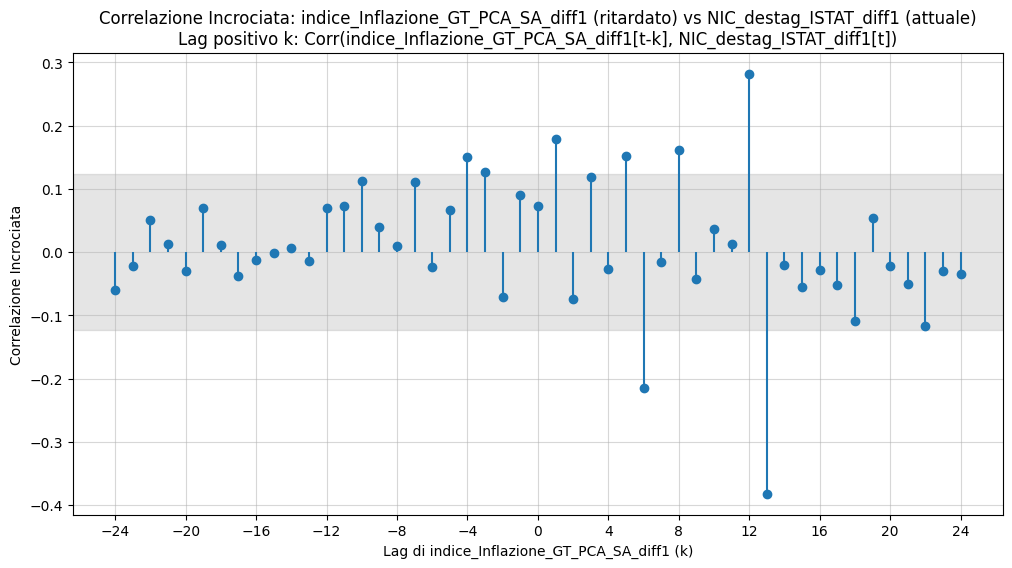

--- Fine CCF ---

--- Calcolo CCF tra: indice_Tematico_GT_SA_diff1 (x) e NIC_destag_ISTAT_diff1 (y) ---
Grafico CCF salvato in: /Users/tommaso/Desktop/tesi-inflation-gt/Analisi_Correlazione_Incrociata_(CCF)/grafici_fase3_ccf/ccf_indice_tematico_gt_sa_diff1_vs_nic_destag_istat_diff1.png


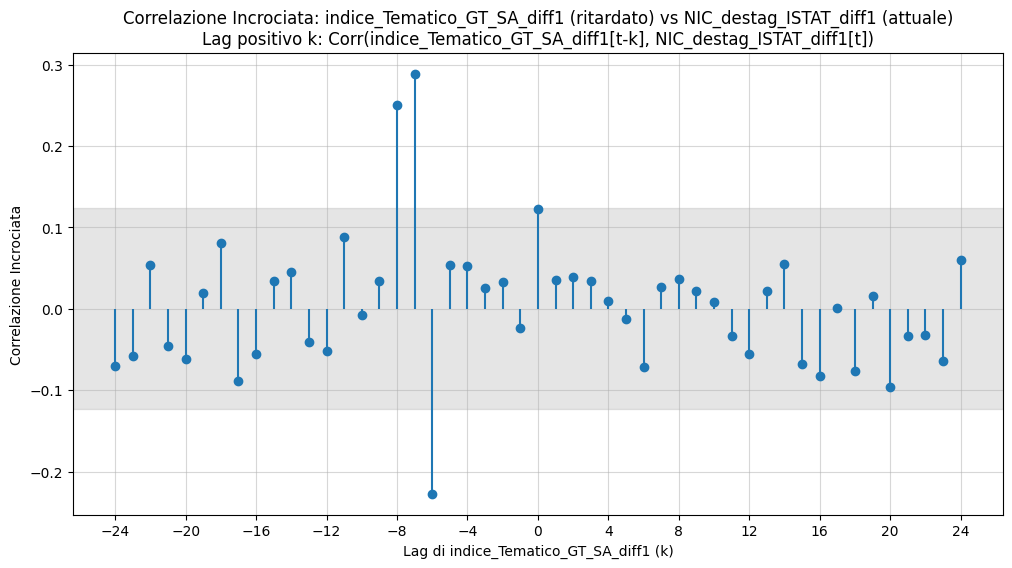

--- Fine CCF ---


>>> SCRIPT FASE 3 COMPLETATO <<<


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm # Per la funzione ccf
from statsmodels.graphics.tsaplots import plot_acf # plot_acf può essere usato anche per CCF se passo la cross-correlation

# --- CONFIGURAZIONE ---
# Path al file di input (output della Fase 2 - serie stazionarie)
PATH_INPUT_DIR_FASE2 = "/Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2"
FILE_SERIE_STAZIONARIE_IN = os.path.join(PATH_INPUT_DIR_FASE2, "indici_gt_nic_stazionari_fase2.csv")

# Path per i grafici di output di questa Fase 3 (opzionale, i grafici vengono mostrati)
PATH_OUTPUT_GRAFICI_FASE3 = "/Users/tommaso/Desktop/tesi-inflation-gt/Analisi_Correlazione_Incrociata_(CCF)/grafici_fase3_ccf"

# Nomi delle colonne come salvate nello script precedente
# Le serie stazionarie sono state salvate con suffisso _diff1
COL_INFLAZIONE_STAZ = 'NIC_destag_ISTAT_diff1'
COL_GT_INFLAZIONE_STAZ = 'indice_Inflazione_GT_PCA_SA_diff1'
COL_GT_TEMATICO_STAZ = 'indice_Tematico_GT_SA_diff1'

MAX_LAGS_CCF = 24 # Numero massimo di ritardi da considerare per la CCF

# --- FUNZIONI AUSILIARIE ---
def carica_dati_stazionari(path_file):
    """
    Carico le serie stazionarie (o trasformate) dal CSV salvato dalla Fase 2.
    """
    print(f"--- Caricamento Serie Stazionarie da: {path_file} ---")
    try:
        df = pd.read_csv(path_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        # Non è necessario asfreq se l'indice è già corretto dal salvataggio precedente
        print(f"Serie caricate con successo. Shape: {df.shape}")
        print(f"Indice temporale: da {df.index.min()} a {df.index.max()}")
        print("Prime 5 righe:")
        print(df.head())
        print("--- Fine Caricamento ---\n")
        return df
    except FileNotFoundError:
        print(f"ERRORE: File non trovato: {path_file}")
        return None
    except Exception as e:
        print(f"ERRORE durante il caricamento delle serie stazionarie: {e}")
        return None

def plot_ccf_custom(serie_x, serie_y, nome_x, nome_y, max_lags=24, path_output_grafici=None):
    """
    Calcolo e visualizzo la Funzione di Correlazione Incrociata (CCF) tra due serie stazionarie.
    Mostra la correlazione di y_{t+k} con x_t (k può essere positivo o negativo).
    """
    print(f"--- Calcolo CCF tra: {nome_x} (x) e {nome_y} (y) ---")
    
    # statsmodels.tsa.stattools.ccf calcola la correlazione di y_{t+k} con x_t
    # Un lag positivo k significa che x_t è correlato con y_{t+k} (x anticipa y o y ritarda x)
    # Un lag negativo k significa che x_t è correlato con y_{t-|k|} (y anticipa x o x ritarda y)
    
    # Per coerenza con molti software e interpretazioni, spesso si vuole vedere Cor(x_{t-k}, y_t)
    # Se ccf_xy[k] è Cor(x_t, y_{t+k}), allora Cor(x_{t-j}, y_t) è ccf_xy[-j] (per j>0)
    # e Cor(x_{t+j}, y_t) è ccf_xy[j] (per j>0, il che significa che y anticipa x)
    
    # Unisco le serie e rimuovo i NaN per avere lo stesso campione
    df_merged = pd.concat([serie_x.rename('x'), serie_y.rename('y')], axis=1).dropna()
    
    if df_merged.empty or len(df_merged) < max_lags + 1 : # Controllo se ci sono abbastanza dati
        print(f"Non ci sono abbastanza dati sovrapposti tra {nome_x} e {nome_y} dopo dropna per calcolare CCF con {max_lags} lags.")
        return

    ccf_values_positive_lags = sm.tsa.stattools.ccf(df_merged['x'], df_merged['y'], adjusted=False, fft=False)[:max_lags+1]
    # Per i lag negativi (y che anticipa x), inverto le serie
    ccf_values_negative_lags = sm.tsa.stattools.ccf(df_merged['y'], df_merged['x'], adjusted=False, fft=False)[1:max_lags+1] # Escludo lag 0

    # Combinazione per il plot: [-max_lags, ..., -1, 0, 1, ..., max_lags]
    lags = np.arange(-max_lags, max_lags + 1)
    ccf_plot_values = np.concatenate((np.flip(ccf_values_negative_lags), ccf_values_positive_lags))
    
    plt.figure(figsize=(12, 6))
    plt.stem(lags, ccf_plot_values, basefmt=" ")
    
    # Bande di confidenza approssimati (per white noise)
    n_obs = len(df_merged)
    conf_interval = 1.96 / np.sqrt(n_obs) # Approssimazione per processi non correlati
    plt.axhspan(-conf_interval, conf_interval, alpha=0.2, color='gray', zorder=-10)
    
    plt.title(f"Correlazione Incrociata: {nome_x} (ritardato) vs {nome_y} (attuale)\nLag positivo k: Corr({nome_x}[t-k], {nome_y}[t])")
    plt.xlabel(f"Lag di {nome_x} (k)")
    plt.ylabel(f"Correlazione Incrociata")
    plt.xticks(np.arange(-max_lags, max_lags + 1, step=max(1, max_lags//6) )) # Step per i tick sull'asse x
    plt.grid(True, alpha=0.5)
    
    if path_output_grafici:
        if not os.path.exists(path_output_grafici):
            os.makedirs(path_output_grafici)
        filename = f"ccf_{nome_x}_vs_{nome_y}.png".replace(" ", "_").lower()
        plt.savefig(os.path.join(path_output_grafici, filename))
        print(f"Grafico CCF salvato in: {os.path.join(path_output_grafici, filename)}")
        
    plt.show()
    print("--- Fine CCF ---\n")

# --- ESECUZIONE SCRIPT FASE 3 (Esplorativa - CCF) ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT FASE 3: Analisi Correlazione Incrociata (CCF) <<<\n")

    # Creo la directory di output per i grafici se non esiste
    os.makedirs(PATH_OUTPUT_GRAFICI_FASE3, exist_ok=True)
    print(f"Directory di output per i grafici di questa fase: '{PATH_OUTPUT_GRAFICI_FASE3}'\n")

    # 1. Carico le serie stazionarie (o trasformate) dalla Fase 2
    df_serie_stazionarie = carica_dati_stazionari(FILE_SERIE_STAZIONARIE_IN)

    if df_serie_stazionarie is None:
        print("ERRORE CRITICO: Impossibile caricare il file delle serie stazionarie. Script interrotto.")
        exit()

    # 2. Preparo le serie per l'analisi CCF
    # Mi assicuro che le colonne esistano prima di tentare di accedervi
    serie_inflazione = None
    serie_gt_inflazione = None
    serie_gt_tematico = None

    if COL_INFLAZIONE_STAZ in df_serie_stazionarie.columns:
        serie_inflazione = df_serie_stazionarie[COL_INFLAZIONE_STAZ].dropna()
    else:
        print(f"ERRORE: Colonna inflazione '{COL_INFLAZIONE_STAZ}' non trovata nel file caricato.")

    if COL_GT_INFLAZIONE_STAZ in df_serie_stazionarie.columns:
        serie_gt_inflazione = df_serie_stazionarie[COL_GT_INFLAZIONE_STAZ].dropna()
    else:
        print(f"ERRORE: Colonna GT inflazione '{COL_GT_INFLAZIONE_STAZ}' non trovata nel file caricato.")
        
    if COL_GT_TEMATICO_STAZ in df_serie_stazionarie.columns:
        serie_gt_tematico = df_serie_stazionarie[COL_GT_TEMATICO_STAZ].dropna()
    else:
        print(f"ERRORE: Colonna GT tematico '{COL_GT_TEMATICO_STAZ}' non trovata nel file caricato.")

    # 3. Eseguo e visualizzo le CCF
    # CCF tra inflazione (y) e indice_Inflazione_GT_PCA_SA_diff1 (x)
    if serie_inflazione is not None and serie_gt_inflazione is not None:
        plot_ccf_custom(serie_gt_inflazione, serie_inflazione,
                        nome_x=COL_GT_INFLAZIONE_STAZ,
                        nome_y=COL_INFLAZIONE_STAZ,
                        max_lags=MAX_LAGS_CCF,
                        path_output_grafici=PATH_OUTPUT_GRAFICI_FASE3)
    else:
        print(f"Skippo CCF per '{COL_GT_INFLAZIONE_STAZ}' vs '{COL_INFLAZIONE_STAZ}' a causa di dati mancanti.")

    # CCF tra inflazione (y) e indice_Tematico_GT_SA_diff1 (x)
    if serie_inflazione is not None and serie_gt_tematico is not None:
        plot_ccf_custom(serie_gt_tematico, serie_inflazione,
                        nome_x=COL_GT_TEMATICO_STAZ,
                        nome_y=COL_INFLAZIONE_STAZ,
                        max_lags=MAX_LAGS_CCF,
                        path_output_grafici=PATH_OUTPUT_GRAFICI_FASE3)
    else:
        print(f"Skippo CCF per '{COL_GT_TEMATICO_STAZ}' vs '{COL_INFLAZIONE_STAZ}' a causa di dati mancanti.")
        
    print("\n>>> SCRIPT FASE 3 COMPLETATO <<<")
